In [1]:
import numpy as np
import mmwave.dsp as dsp
from mmwave.dataloader import DCA1000
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def generate_spectrum_from_RDC(filename, numFrames = 500, numADCSamples = 128, numTxAntennas = 3, numRxAntennas = 4, 
                               numLoopsPerFrame = 128, numAngleBins = 64, chirpPeriod = 0.06, logGabor=False, accumulate=True):
    numChirpsPerFrame = numTxAntennas * numLoopsPerFrame
    
# =============================================================================
#     numADCSamples = number of range bins
#     numLoopsPerFrame = number of doppler bins
# =============================================================================

    range_resolution, bandwidth = dsp.range_resolution(numADCSamples)
    doppler_resolution = dsp.doppler_resolution(bandwidth)
    
    if filename[-4:] != '.bin':
        filename += '.bin'
        
    adc_data = np.fromfile(filename, dtype=np.int16)
    adc_data = adc_data.reshape(numFrames, -1)
    adc_data = np.apply_along_axis(DCA1000.organize, 1, adc_data, num_chirps=numChirpsPerFrame,
                                    num_rx=numRxAntennas, num_samples=numADCSamples)
    print("Data Loaded!")

    dataCube = adc_data
    micro_doppler_data = np.zeros((numFrames, numLoopsPerFrame, numADCSamples), dtype=np.float64)
    
    for i, frame in enumerate(dataCube):
        # (2) Range Processing
        from mmwave.dsp.utils import Window

        radar_cube = dsp.range_processing(frame, window_type_1d=Window.BLACKMAN)
        assert radar_cube.shape == (
        numChirpsPerFrame, numRxAntennas, numADCSamples), "[ERROR] Radar cube is not the correct shape!"

        # (3) Doppler Processing 
        det_matrix , aoa_input = dsp.doppler_processing(radar_cube, num_tx_antennas=3, clutter_removal_enabled=True, window_type_2d=Window.HAMMING)
        
        # --- Shifts & Store
        det_matrix_vis = np.fft.fftshift(det_matrix, axes=1)                
        micro_doppler_data[i,:,:] = det_matrix_vis
        # Data should now be ready. Needs to be in micro_doppler_data, a 3D-numpy array with shape [numDoppler, numRanges, numFrames]
    
        # LOG GABOR
        if logGabor:
            if accumulate:
                image = micro_doppler_data.sum(axis=1).T
            else:
                image = micro_doppler_data.T
    
            from LogGabor import LogGabor
            import holoviews as hv
    
            lg = LogGabor("default_param.py")
            lg.set_size(image)
            lg.pe.datapath = 'database/'
    
            image = lg.normalize(image, center=True)
    
            # display input image
            # hv.Image(image)
    
            # display log gabor'd image
            image = lg.whitening(image)*lg.mask
            hv.Image(image)
    
            uDoppler = image
        elif accumulate:
            uDoppler = micro_doppler_data.sum(axis=1).T
        else:
            uDoppler = micro_doppler_data.T
            
    return range_resolution, doppler_resolution, uDoppler

In [3]:
def microdoppler_visualizer(uDoppler):
    from matplotlib.widgets import Slider, Button, RadioButtons
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    img = plt.imshow(uDoppler[:,0,:], aspect='auto')
    ax.margins(x=0)
    
    axcolor = 'lightgoldenrodyellow'
    range_idx = plt.axes([0.25, 0.1, 0.65, 0.03], facecolor=axcolor)
    
    srange = Slider(range_idx, 'Range', 1, uDoppler.shape[1], valinit=0, valstep=1)    
    
    def update(val):
        r = int(srange.val)
        img.set_data(uDoppler[:,r,:])
        img.autoscale()
        fig.canvas.draw_idle()
    
    
    srange.on_changed(update)
    
    resetax = plt.axes([0.8, 0.025, 0.1, 0.04])
    button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
    
    
    def reset(event):
        srange.reset()
    button.on_clicked(reset)
    
    rax = plt.axes([0.025, 0.5, 0.15, 0.15], facecolor=axcolor)
    radio = RadioButtons(rax, ('red', 'blue', 'green'), active=0)
    
    
    def colorfunc(label):
        img.set_color(label)
        fig.canvas.draw_idle()
    radio.on_clicked(colorfunc)
    
    plt.show()

In [4]:
chirpPeriod = 0.06 # unit?
range_resolution, doppler_resolution, uDoppler = generate_spectrum_from_RDC('./data/uDoppler1.bin', accumulate=False)

Data Loaded!


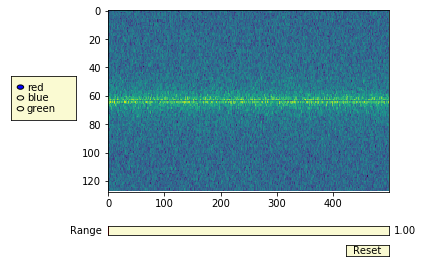

In [5]:
microdoppler_visualizer(uDoppler)

NameError: name 'widgets' is not defined

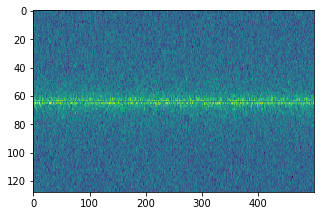

In [11]:
def microdoppler_visualizer_2p0(uDoppler):
    import ipywidgets as widgets
    from ipywidgets import interact
    
    fig, ax = plt.subplots()
    plt.subplots_adjust(left=0.25, bottom=0.25)
    img = plt.imshow(uDoppler[:,0,:], aspect='auto')
    ax.margins(x=0)
    
    srange = widgets.IntSlider()
    
    button = widgets.Button(description='Plot',)
    @button.on_click
    def plot_on_click(b):
        plot()
    
    def update():
        r = int(srange.val)
        img.set_data(uDoppler[:,r,:])
        img.autoscale()
        fig.canvas.draw_idle()

microdoppler_visualizer_2p0(uDoppler)
widgets.IntSlider()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

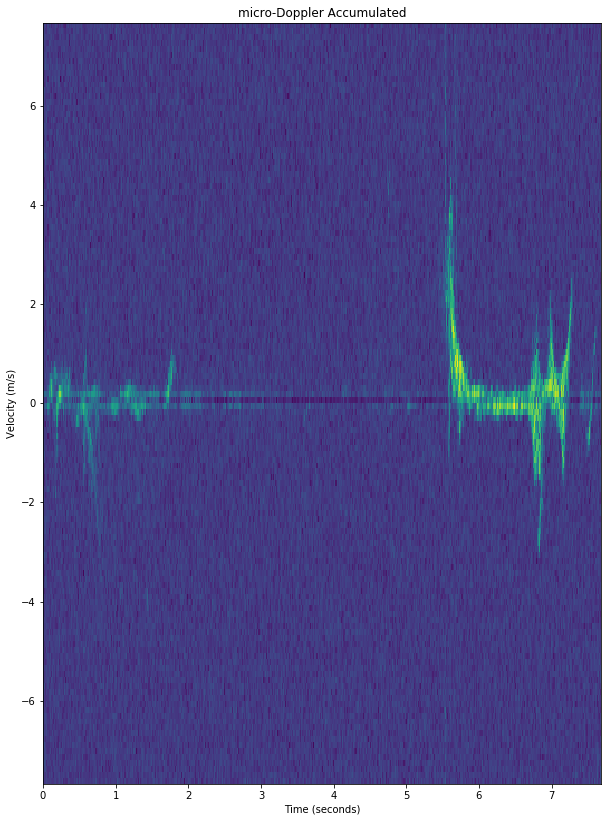

In [15]:
plt.figure(1)
plt.title("micro-Doppler Accumulated")
plt.ylabel("Velocity (m/s)")
plt.xlabel("Time (seconds)")
plt.imshow(uDoppler[:,120,:],origin='lower',aspect='auto',extent=(0,chirpPeriod*uDoppler[:,120,:].shape[0],-uDoppler[:,120,:].shape[1]*doppler_resolution/2,uDoppler[:,120,:].shape[1]*doppler_resolution/2))
fig = plt.gcf()
fig.set_size_inches(10, 14)
plt.show()

In [2]:
import ipyvolume